In [1]:
import re
import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import lxml.html as lx
import xml.etree.ElementTree as ET
from lxml import etree
import time
#from google.colab import drive
#drive.mount('/content/gdrive')
from sklearn.preprocessing import StandardScaler

# Preprocessing #

In [ ]:
url = 'https://letterboxd.com/fcbarcelona/list/movies-everyone-should-watch-at-least-once/page/'

In [ ]:
link_list = [] #contains all movie urls
for page in range(1,8):
  curr_url = f'{url}{page}'
  result = requests.get(curr_url).text
  links = re.findall(r"(?<=data-target-link=\").*?(?=\")", result)
  for link in links:
    link_list.append(link)

In [ ]:
link_list[234]

'/film/my-life-as-a-dog/'

In [ ]:
movies_dict = {}
'''
sample entry
{Movie Name: {Rating : Value}, #done
             {Likes : Value},
             {Top Cast: List},
             {Director: List},
             {Genre: List}, #done
             {Language: List}}
'''

'\nsample entry\n{Movie Name: {Rating : Value}, #done\n             {Likes : Value},\n             {Top Cast: List},\n             {Director: List},\n             {Genre: List}, #done\n             {Language: List}}\n'

In [ ]:
def fetch_details(movie_link):
    url = f'https://letterboxd.com{movie_link}'
    result = requests.get(url).text

    time.sleep(0.5)

    movie_title = re.findall(r"(?<=\"og:title\" content=\").*?(?= \()", result)[0]
    if "&#039;" in movie_title:
      movie_title = movie_title.replace( "&#039;", "'")
    if 'amp;' in movie_title:
      movie_title = movie_title.replace( 'amp;', "")

    rating = float(re.findall(r"(?<=\"ratingValue\":).*?(?=\,)", result)[0])

    likes_result = requests.get(f'{url}likes').text
    likes_data = lx.fromstring(likes_result).xpath("//a[contains(@href, 'likes')]/@title")
    likes_data = likes_data[0].replace(',','')
    likes = int(re.findall(r'\d+', likes_data)[0])


    genre_parse = re.findall(r"(?<=\"genre\":\[)\".*?\"(?=\]\,)", result)
    genre_parse = genre_parse[0].split(',')
    genre_list = [genre.strip('"') for genre in genre_parse][0]

    top_3_cast = lx.fromstring(result).xpath("//a[contains(@href, 'actor')]/text()")[:3]

    primary_language = lx.fromstring(result).xpath("//a[contains(@href, 'language')]/text()")[:1][0]

    director = lx.fromstring(result).xpath("//a[contains(@href, '/director/')]/text()")[0]


    return {'title': movie_title,
            'rating': rating,
            'likes' : likes,
            'genre' : genre_list,
            'top cast': top_3_cast,
            'language': primary_language,
            'director': director
            }

In [ ]:
for i in link_list:
  movie = fetch_details(i)
  movies_dict[movie['title']] = movie

In [ ]:
fetch_details(link_list[67])

{'title': 'In the Mood for Love',
 'rating': 4.4,
 'likes': 272405,
 'genre': 'Drama',
 'top cast': ['Tony Leung Chiu-wai', 'Maggie Cheung', 'Rebecca Pan'],
 'language': 'Cantonese',
 'director': 'Wong Kar-wai'}

In [ ]:
df = pd.DataFrame(movies_dict)
movies_df = df.T.iloc[:, 1:]

In [ ]:
#creating csv
pthname = '/content/gdrive/My Drive/Colab Notebooks/letterboxd.csv'
movies_df.to_csv(pthname)

In [ ]:
#creating a data frame with animated movied to compare with rotten tomatoes ratings
def has_animation(lst):
    return 'Animation' in lst

filtered_rows = movies_df[movies_df['genre'].apply(has_animation)]

# Getting the indices of filtered rows
indices = filtered_rows.index.tolist()
animation_df = movies_df.loc[indices]
pthname = '/content/gdrive/My Drive/Colab Notebooks/animation_letterboxd.csv'
animation_df.to_csv(pthname)

In [134]:
#Reading the animation csv file
df_animation = pd.read_csv('rotten_animation.csv')
df_animation.head(2)

,title,url,run again,critic rating,audience rating
0,The Prince of Egypt,https://www.rottentomatoes.com/m/prince_of_egypt,False,79.0,89.0
1,Spirited Away,https://www.rottentomatoes.com/m/the_super_mar...,False,59.0,95.0


In [135]:
#Correcting Errors (leave them in separate blocks for ease of running)
df_animation.loc[1, 'url'] = 'https://www.rottentomatoes.com/m/spirited_away'
info1 = fetch_details_rotten(df_animation.loc[1, 'title']+ '     ', "['Daveigh Chase, Suzanne Pleshette']")
df_animation.loc[1, 'critic rating'] = float(info1['critic rating'])
df_animation.loc[1, 'audience rating'] = float(info1['audience rating'])

df_animation.loc[5, 'url'] = 'https://www.rottentomatoes.com/m/kung_fu_panda'
df_animation.loc[5, 'critic rating'] = float(87)
df_animation.loc[5, 'audience rating'] = float(83)

df_animation.loc[7, 'url'] = 'https://www.rottentomatoes.com/m/toy_story'
df_animation.loc[7, 'critic rating'] = float(100)
df_animation.loc[7, 'audience rating'] = float(92)

https://www.rottentomatoes.com/search?search=Spirited%20Away%20%20%20%20%20Daveigh%20Chase%20Suzanne%20Pleshette


In [136]:
df_animation.loc[14, 'url'] = 'https://www.rottentomatoes.com/m/princess_mononoke'
info14 = fetch_details_rotten(df_animation.loc[14, 'title'], "['Claire Danes', 'Billy Bob Thornton']")
df_animation.loc[14, 'critic rating'] = float(info14['critic rating'])
df_animation.loc[14, 'audience rating'] = float(info14['audience rating'])

https://www.rottentomatoes.com/search?search=Princess%20MononokeClaire%20Danes%20Billy%20Bob%20Thornton


In [137]:
df_animation.loc[15, 'url'] = 'https://www.rottentomatoes.com/m/shrek_2001'
info15 = fetch_details_rotten(df_animation.loc[15, 'title'], "['Eugenio Derbez', 'Nora Gutierrez']")
df_animation.loc[15, 'critic rating'] = None
df_animation.loc[15, 'audience rating'] = float(info15['audience rating'])

https://www.rottentomatoes.com/search?search=ShrekEugenio%20Derbez%20Nora%20Gutierrez


In [138]:
df_animation.loc[16, 'url'] = 'https://www.rottentomatoes.com/m/my_neighbor_totoro'
info16 = fetch_details_rotten(df_animation.loc[16, 'title'], "['Elle Fanning', 'Dakota Fanning']")
df_animation.loc[16, 'critic rating'] = float(info16['critic rating'])
df_animation.loc[16, 'audience rating'] = float(info16['audience rating'])

https://www.rottentomatoes.com/search?search=My%20Neighbor%20TotoroElle%20Fanning%20Dakota%20Fanning


In [139]:
df_animation.loc[19, 'url'] = 'https://www.rottentomatoes.com/m/fantastic_planet'
info19 = fetch_details_rotten(df_animation.loc[19, 'title'], "['Barry Bostwick', 'Mark Gruner']")
df_animation.loc[19, 'critic rating'] = float(info19['critic rating'])
df_animation.loc[19, 'audience rating'] = float(info19['audience rating'])

https://www.rottentomatoes.com/search?search=Fantastic%20PlanetBarry%20Bostwick%20Mark%20Gruner


In [140]:
df_animation.loc[24, 'url'] = 'https://www.rottentomatoes.com/m/howls_moving_castle'
info24 = fetch_details_rotten(df_animation.loc[24, 'title'], "['Jean Simmons', 'Christian Bale']")
df_animation.loc[24, 'critic rating'] = float(info24['critic rating'])
df_animation.loc[24, 'audience rating'] = float(info24['audience rating'])

https://www.rottentomatoes.com/search?search=Howl's%20Moving%20CastleJean%20Simmons%20Christian%20Bale


In [141]:
df_animation.loc[27, 'critic rating'] = 98.0
df_animation.loc[28, 'critic rating'] = 95.0
df_animation.loc[28, 'audience rating'] = 89.0
df_animation.loc[34, 'critic rating'] = 100.0
df_animation.loc[34, 'audience rating'] = 90.0
df_animation.loc[35, 'critic rating'] = 100.0
df_animation.loc[35, 'audience rating'] = 82.0
df_animation.loc[37, 'critic rating'] = 100.0
df_animation.loc[37, 'audience rating'] = 94.0
df_animation.loc[38, 'critic rating'] = 95.0
df_animation.loc[41, 'critic rating'] = 91.0
df_animation.loc[41, 'audience rating'] = 83.0
df_animation.loc[42, 'critic rating'] = 97.0
df_animation.loc[42, 'audience rating'] = 75.0
df_animation.loc[43, 'critic rating'] = 86.0
df_animation.loc[43, 'audience rating'] = 87.0
df_animation.loc[45, 'critic rating'] = 99.0
df_animation.loc[45, 'audience rating'] = 89.0
df_animation = df_animation.drop(['url', 'run again'], axis=1)
df_animation.loc[50] = ['Perfect Blue', 83.0, 89.0]
original_animation_df = pd.read_csv('animation_letterboxd.csv')
merged_ani_df = pd.concat([original_animation_df.copy(), df_animation.copy()], axis = 1)
merged_ani_df.loc[49, ['critic rating', 'audience rating']] = [83.0, 89.0]
merged_ani_df = merged_ani_df.iloc[:-1, :]
merged_ani_df = merged_ani_df.drop(['Unnamed: 0.1', 'title', 'top cast'], axis = 1)
merged_ani_df = merged_ani_df.rename({"Unnamed: 0": "title"}, axis = 1)
#merged_ani_df.head(50)
merged_ani_dfplot = merged_ani_df
merged_ani_dfplot.fillna(0, inplace=True)

merged_ani_dfplot

,title,rating,likes,genre,language,director,n_rating,critic rating,audience rating
0,The Prince of Egypt,3.99,110193.0,"['Adventure', 'Animation', 'Family', 'Drama']",English,Simon Wells,0.850746,79.0,89.0
1,Spirited Away,4.46,1204588.0,"['Family', 'Fantasy', 'Animation']",Japanese,Hayao Miyazaki,0.950959,96.0,96.0
2,Spider-Man: Into the Spider-Verse,4.43,1654380.0,"['Adventure', 'Animation', 'Science Fiction', ...",English,Rodney Rothman,0.944563,97.0,94.0
3,A Silent Voice,4.15,161321.0,"['Drama', 'Animation']",Japanese,Naoko Yamada,0.884861,94.0,93.0
4,Finding Nemo,4.04,596281.0,"['Animation', 'Family']",English,Andrew Stanton,0.861407,99.0,86.0
5,Kung Fu Panda,3.83,294240.0,"['Comedy', 'Action', 'Family', 'Adventure', 'A...",English,Mark Osborne,0.816631,87.0,83.0
6,Akira,4.27,257590.0,"['Animation', 'Action', 'Science Fiction']",Japanese,Katsuhiro Otomo,0.910448,91.0,90.0
7,Toy Story,4.13,632705.0,"['Comedy', 'Animation', 'Family', 'Adventure']",English,John Lasseter,0.880597,100.0,92.0
8,The Lion King,4.21,560975.0,"['Animation', 'Family', 'Drama']",English,Roger Allers,0.897655,76.0,62.0
9,Up,4.09,808338.0,"['Animation', 'Adventure', 'Family', 'Comedy']",English,Pete Docter,0.872068,98.0,90.0


In [142]:
merged_ani_dfplot.to_csv('final_animation_with_rotten.csv', index = False)

#UPLOADING DOCS

In [ ]:
from google.colab import files

uploaded = files.upload()

file_name = list(uploaded.keys())[0]

file_path = f'/content/{file_name}'
print(f'File uploaded to: {file_path}')


Saving rotten_animation.csv to rotten_animation.csv
File uploaded to: /content/rotten_animation.csv


# START HERE TO NOT RERUN THE CODE #

In [2]:
pre_movies_df = pd.read_csv('letterboxd.csv')
animation_df = pd.read_csv('rotten_animation.csv')

In [3]:
#Just some processing steps after reading the letterboxd.csv file in
#We want lists, but our lists have been converting to strings, which we have to rectify for our visualizations
count = 0
top_cast_adjusted = []
genres_adjusted = []

for actors in pre_movies_df['top cast']:
    actors = re.findall(r"'([^']*)'", actors)
    top_cast_adjusted.append(actors)

for genres in pre_movies_df['genre']:
    genres = re.findall(r"'([^']*)'", genres)
    genres_adjusted.append(genres)


movies_df = pre_movies_df[['Unnamed: 0', 'rating', 'likes', 'language', 'director']].copy()
movies_df['genre'] = genres_adjusted
movies_df['top cast'] = top_cast_adjusted
movies_df = movies_df.rename(columns={'Unnamed: 0': 'title'})
movies_df.head()

,title,rating,likes,language,director,genre,top cast
0,Psycho,4.32,403790,English,Alfred Hitchcock,"[Mystery, Thriller, Horror]","[Anthony Perkins, Janet Leigh, Vera Miles]"
1,2001: A Space Odyssey,4.30,447180,English,Stanley Kubrick,"[Adventure, Mystery, Science Fiction]","[Keir Dullea, Gary Lockwood, William Sylvester]"
2,Schindler's List,4.52,356548,English,Steven Spielberg,"[History, Drama, War]","[Liam Neeson, Ben Kingsley, Ralph Fiennes]"
3,GoodFellas,4.48,596488,English,Martin Scorsese,"[Drama, Crime]","[Ray Liotta, Robert De Niro, Joe Pesci]"
4,Back to the Future,4.20,777751,English,Robert Zemeckis,"[Comedy, Science Fiction, Adventure]","[Michael J. Fox, Christopher Lloyd, Crispin Gl..."


In [4]:
#Adding a column with normalized ratings
movies_df['n_rating'] = movies_df['rating']/movies_df['rating'].abs().max()
movies_df.head(10)

,title,rating,likes,language,director,genre,top cast,n_rating
0,Psycho,4.32,403790,English,Alfred Hitchcock,"[Mystery, Thriller, Horror]","[Anthony Perkins, Janet Leigh, Vera Miles]",0.921109
1,2001: A Space Odyssey,4.30,447180,English,Stanley Kubrick,"[Adventure, Mystery, Science Fiction]","[Keir Dullea, Gary Lockwood, William Sylvester]",0.916844
2,Schindler's List,4.52,356548,English,Steven Spielberg,"[History, Drama, War]","[Liam Neeson, Ben Kingsley, Ralph Fiennes]",0.963753
3,GoodFellas,4.48,596488,English,Martin Scorsese,"[Drama, Crime]","[Ray Liotta, Robert De Niro, Joe Pesci]",0.955224
4,Back to the Future,4.20,777751,English,Robert Zemeckis,"[Comedy, Science Fiction, Adventure]","[Michael J. Fox, Christopher Lloyd, Crispin Gl...",0.895522
5,Lawrence of Arabia,4.35,79471,English,David Lean,"[Adventure, War, History]","[Toole"", , , ]",0.927505
6,The Virgin Suicides,3.82,244142,English,Sofia Coppola,"[Romance, Drama]","[James Woods, Kathleen Turner, Kirsten Dunst]",0.814499
7,Come and See,4.64,122563,Russian,Elem Klimov,"[War, Drama]","[Aleksei Kravchenko, Olga Mironova, Liubomiras...",0.989339
8,The Prince of Egypt,3.99,110193,English,Simon Wells,"[Adventure, Animation, Family, Drama]","[Val Kilmer, Ralph Fiennes, Michelle Pfeiffer]",0.850746
9,The Princess Bride,4.04,303186,English,Rob Reiner,"[Adventure, Romance, Fantasy, Family, Comedy]","[Cary Elwes, Robin Wright, Mandy Patinkin]",0.861407


#DIRECTORS

In [5]:
#Selecting top 50 directors in data frame and isolating them
director_list = movies_df['director'].value_counts().index.tolist()[:50]
director_df = movies_df[movies_df['director'].isin(director_list)]
director_df_group = director_df.groupby('director')

#creating dictionary with number of times they appear, avg rating + likes
director_rating_likes = {}
for director in director_list:
  temp_df = director_df_group.get_group(director)
  film_count = len(temp_df)
  agg_rating = temp_df['rating'].mean()
  agg_likes = temp_df['likes'].mean()
  director_rating_likes[director] = {'average rating' : round(agg_rating, 2),
                                     'average likes' : int(agg_likes),
                                     'number of films' : film_count}
director_rating_likes_df = pd.DataFrame(director_rating_likes).T

In [ ]:
#finding out top 10 rated directors and creating a data frame
director_rating_likes_df = director_rating_likes_df.sort_values(by='average rating', ascending=False)
top_rated_directors_df = director_rating_likes_df.iloc[:10, :]
top_rated_directors = top_rated_directors_df.index.tolist()
top_rated_df = movies_df[movies_df['director'].isin(top_rated_directors)]

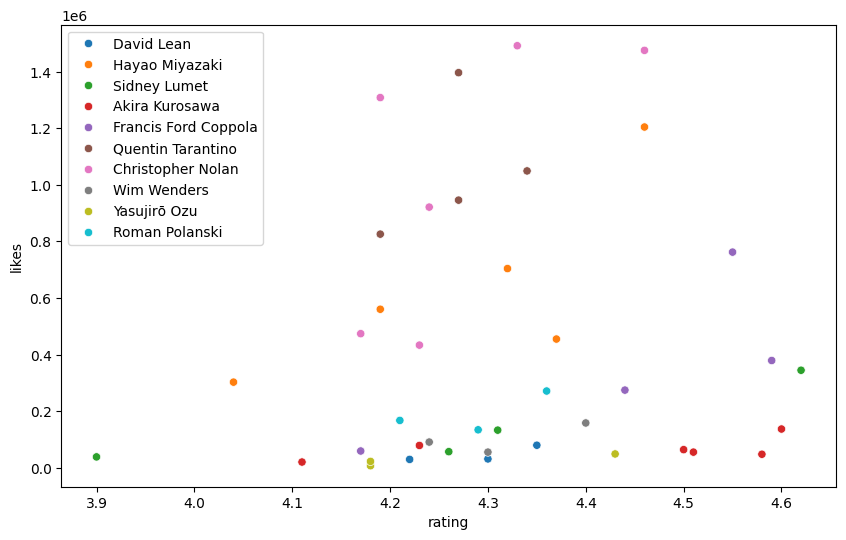

In [ ]:
#scatter plot of likes vs ratings, color coded by director
import seaborn as sns
plt.figure(figsize=(10, 6))
sns.scatterplot(data=top_rated_df,
                x=top_rated_df['rating'],
                y=top_rated_df['likes'],
                hue=top_rated_df['director'])
plt.legend(loc='upper left')

#GENRES

In [7]:
#Sorting by Genre and plotting rating
import seaborn as sns
import matplotlib.pyplot as plt

movies_df['genre']

sorting_genre_data = []

for rating, genres in zip(movies_df['rating'], movies_df['genre']):
    for genre in genres:
        sorting_genre_data.append((rating, genre))

genre_df = pd.DataFrame(sorting_genre_data, columns = ['rating', 'genre'])
genre_df.head(10)

,rating,genre
0,4.32,Mystery
1,4.32,Thriller
2,4.32,Horror
3,4.30,Adventure
4,4.30,Mystery
5,4.30,Science Fiction
6,4.52,History
7,4.52,Drama
8,4.52,War
9,4.48,Drama


In [ ]:
#Getting an idea of the different genres (17) and how many movies of each genre there are
print(genre_df['genre'].unique())
genre_df['genre'].value_counts()

['Mystery' 'Thriller' 'Horror' 'Adventure' 'Science Fiction' 'History'
 'Drama' 'War' 'Crime' 'Comedy' 'Romance' 'Animation' 'Family' 'Fantasy'
 'Action' 'Music' 'Western']


Drama              469
Comedy             197
Thriller           138
Romance            137
Crime              130
Action              77
Adventure           76
Mystery             69
Fantasy             62
Family              57
Science Fiction     53
Animation           50
Horror              46
War                 37
History             35
Music               21
Western              9
Name: genre, dtype: int64

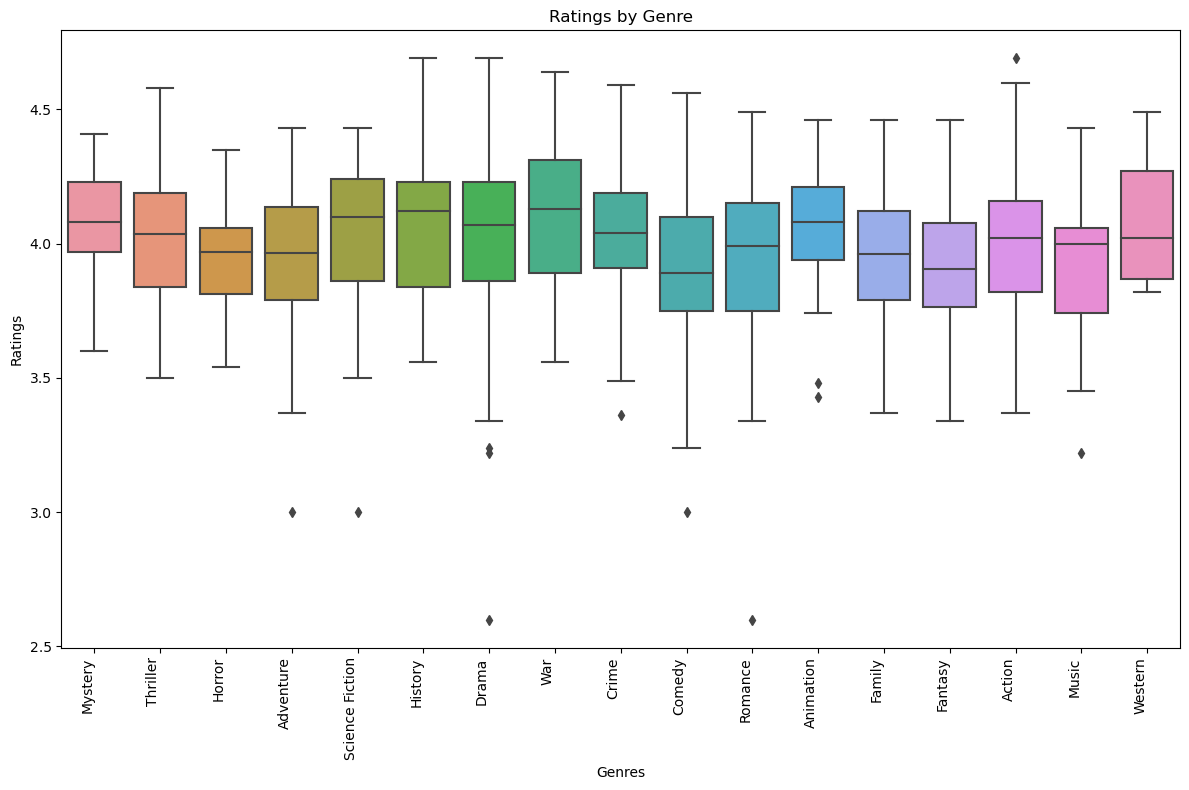

In [8]:
#Boxplots to get an idea of spread of ratings for each genre (we should have 17 boxplots)
plt.figure(figsize=(12, 8))
sns.boxplot(x='genre', y='rating', data=genre_df)
plt.title('Ratings by Genre')
plt.xlabel('Genres')
plt.ylabel('Ratings')
plt.xticks(rotation=90, ha='right')
plt.tight_layout()
plt.show()

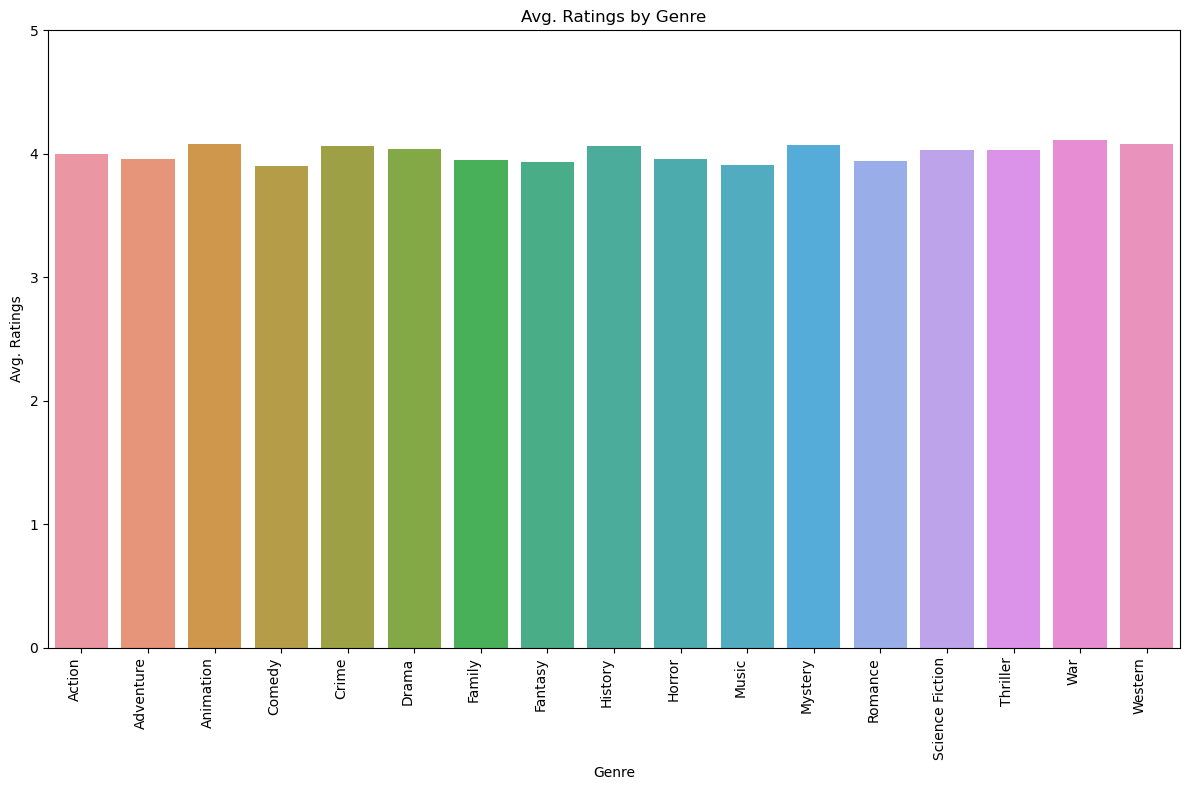

In [9]:
#Bar Graphs using the mean rating of each Genre (again, there should be 17 bars, each representing the avg rating of movies of that genre)
genre_means = round(genre_df.groupby('genre')['rating'].mean().reset_index(), 2)
genre_means.head(17)

plt.figure(figsize=(12, 8))
sns.barplot(x='genre', y='rating', data=genre_means)
plt.title('Avg. Ratings by Genre')
plt.xlabel('Genre')
plt.ylabel('Avg. Ratings')
plt.ylim(0, 5)
plt.xticks(rotation=90, ha='right')
plt.tight_layout()
plt.show()

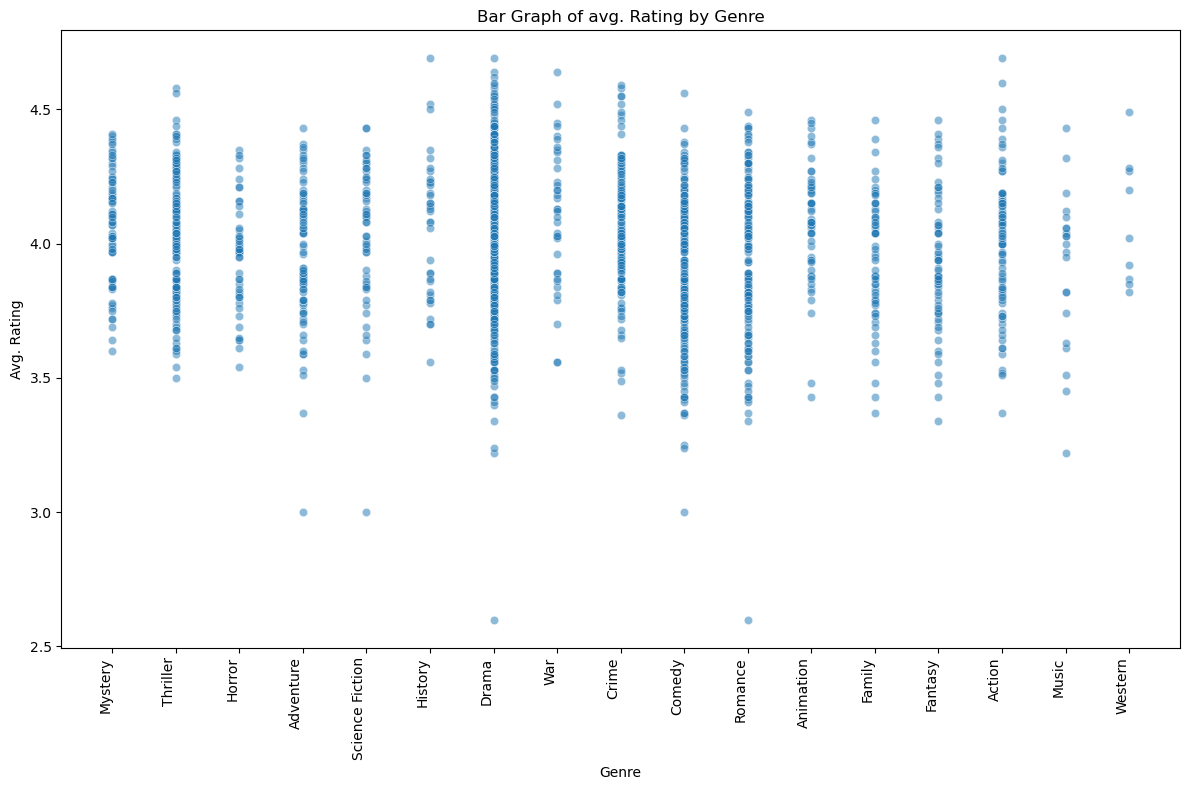

In [10]:
#Scatterplot of ratings by Genre (similar to the boxplot but better visualization of spread)
plt.figure(figsize=(12, 8))
sns.scatterplot(x='genre', y='rating', data=genre_df, alpha=0.5)
plt.title('Bar Graph of avg. Rating by Genre')
plt.xlabel('Genre')
plt.ylabel('Avg. Rating')
plt.xticks(rotation=90, ha='right')
plt.tight_layout()
plt.show()

<Axes: xlabel='rating', ylabel='likes'>

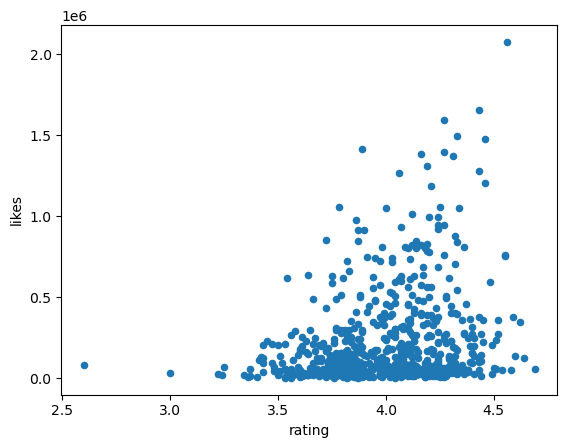

In [11]:
#Plotting rating against likes
movies_df.plot.scatter(x= 'rating', y='likes')

#LANGUAGE

In [ ]:
#Getting an idea of the number of movies in each language
movies_df['language'].value_counts()

English               522
Japanese               38
French                 34
Spanish                14
Italian                13
German                  8
Korean                  7
Swedish                 6
Persian (Farsi)         5
Russian                 5
Chinese                 5
Cantonese               5
Danish                  4
Portuguese              2
Polish                  2
No spoken language      2
Telugu                  1
Indonesian              1
Norwegian               1
Turkish                 1
Romanian                1
Tswana                  1
Dutch                   1
Arabic                  1
Name: language, dtype: int64

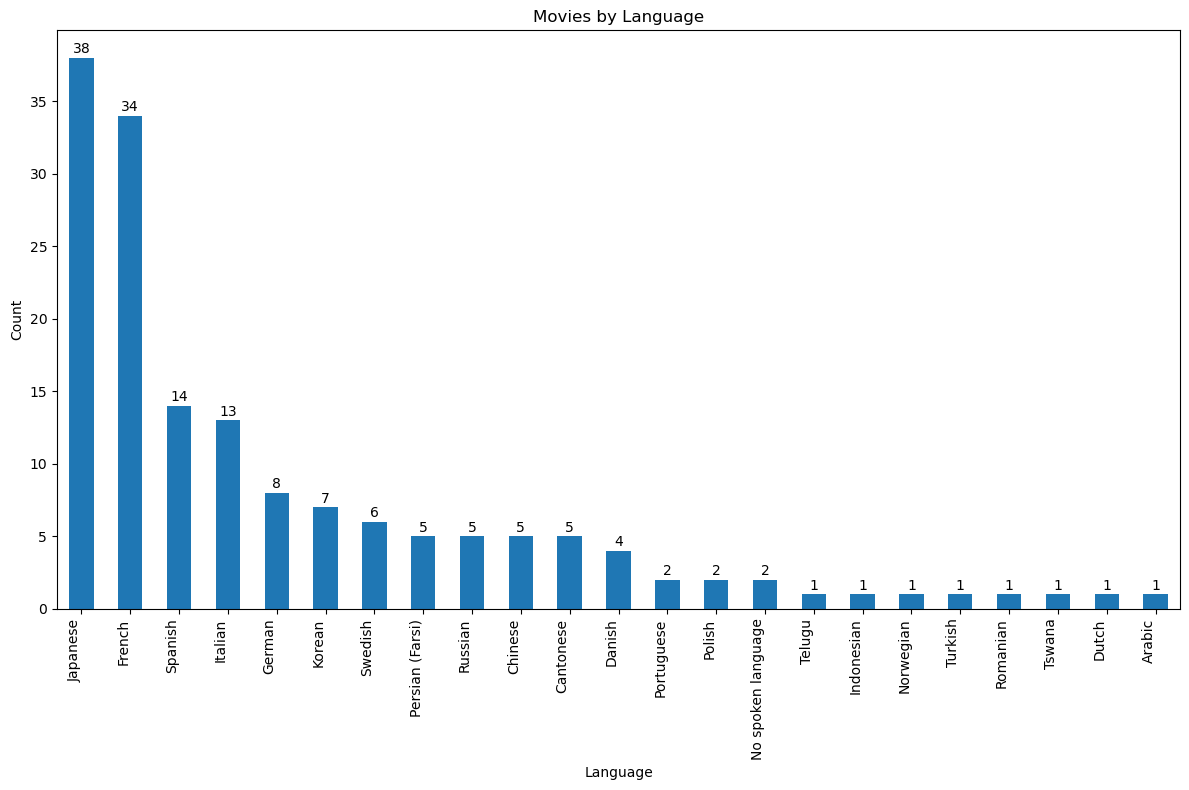

In [12]:
#Bar Graphs of count of each movie by Language (excluding English as English has over 500 movies whereas the other languages ave less than 50)
language_counts = movies_df['language'].value_counts()
language_counts = language_counts.drop('English')
plt.figure(figsize=(12, 8))
language_counts.plot(kind='bar')
plt.title('Movies by Language')
plt.xlabel('Language')
plt.ylabel('Count')
plt.xticks(rotation=90, ha='right')

for i, count in enumerate(language_counts):
    plt.text(i, count + 0.1, str(count), ha='center', va='bottom')

plt.tight_layout()
plt.show()


# TOP TEN MOVIES

In [ ]:
#Isolating the movies with the top ten ratings
movies_df = movies_df.sort_values(by='rating', ascending=False)
top_10_movies = movies_df.iloc[:10,:]
top_10_movies

,title,rating,likes,language,director,genre,top cast,n_rating
24,Harakiri,4.69,59047,Japanese,Masaki Kobayashi,"[History, Drama, Action]","[Tatsuya Nakadai, Akira Ishihama, Shima Iwashita]",1.000000
7,Come and See,4.64,122563,Russian,Elem Klimov,"[War, Drama]","[Aleksei Kravchenko, Olga Mironova, Liubomiras...",0.989339
13,12 Angry Men,4.62,344594,English,Sidney Lumet,[Drama],"[Martin Balsam, John Fiedler, Lee J. Cobb]",0.985075
58,Seven Samurai,4.60,136756,Japanese,Akira Kurosawa,"[Drama, Action]","[Toshirō Mifune, Takashi Shimura, Yoshio Inaba]",0.980810
35,The Godfather: Part II,4.59,379044,English,Francis Ford Coppola,"[Crime, Drama]","[Al Pacino, Robert Duvall, Diane Keaton]",0.978678
14,High and Low,4.58,47576,Japanese,Akira Kurosawa,"[Crime, Drama, Thriller]","[Toshirō Mifune, Tatsuya Nakadai, Kyōko Kagawa]",0.976546
132,Parasite,4.56,2075331,Korean,Bong Joon-ho,"[Comedy, Thriller, Drama]","[Song Kang-ho, Lee Sun-kyun, Cho Yeo-jeong]",0.972281
48,The Godfather,4.55,762284,English,Francis Ford Coppola,"[Crime, Drama]","[Marlon Brando, Al Pacino, James Caan]",0.970149
11,The Shawshank Redemption,4.55,751726,English,Frank Darabont,"[Crime, Drama]","[Tim Robbins, Morgan Freeman, Bob Gunton]",0.970149
305,Yi Yi,4.54,49258,Chinese,Edward Yang,[Drama],"[Wu Nien-jen, Issey Ogata, Elaine Jin]",0.968017


In [ ]:
top_10_movies.value_counts(top_10_movies['language'])

language
English     4
Japanese    3
Chinese     1
Korean      1
Russian     1
dtype: int64

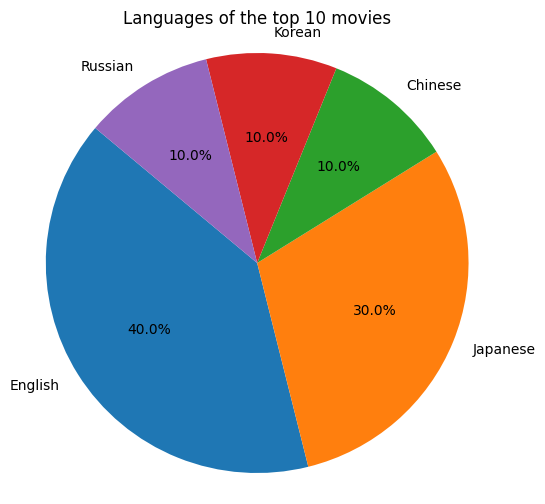

In [ ]:
values = top_10_movies.value_counts(top_10_movies['language']).tolist()
labels = top_10_movies.value_counts(top_10_movies['language']).index.tolist()

plt.figure(figsize=(6, 6))  # Adjust figure size if needed
plt.pie(values, labels=labels, autopct='%1.1f%%', startangle=140)
plt.axis('auto')
plt.title('Languages of the top 10 movies')
plt.show()

# Rotten Tomatoes #


In [26]:
#Creating a function that will get the details (given a title and string of top two actors) of a movie from Rotten Tomatoes
def fetch_details_rotten(title, actors, base_url = "https://www.rottentomatoes.com/search?search=", genre = []):
    session = requests.Session()

    #print(actors)
    cleaned_actors = re.sub(r"['\[\],]", "", actors)
    #print(cleaned_actors)
    cleaned_title = re.sub(r"\s", "%20", title)
    string = re.sub(r"\s", "%20", cleaned_actors)
    #print(string)

    search_url = base_url + cleaned_title + string
    print(search_url)

    response = session.get(search_url).text
    pre_html = lx.fromstring(response)
    url_element = pre_html.xpath('//search-page-result[1]/ul/search-page-media-row/a[2]')[0]
    url = url_element.attrib.get('href', None)

    if url == None:
        return {
            'title': title,
            'url': 'Not Found',
            'run again': True,
            'critic rating': 'Not Listed',
            'audience rating': 'Not Listed'
        }

    #print(title, url)

   # time.sleep(5)

    response = session.get(url).text
    html = lx.fromstring(response)

    rating_path = html.xpath('//score-board-deprecated')[0]

    rating_critic = rating_path.attrib.get('tomatometerscore', 'Not Listed')
    rating_audience = rating_path.attrib.get('audiencescore', 'Not Listed')

    return {'title': title,
                'url': url,
                'run again': False,
                'critic rating': rating_critic,
                'audience rating': rating_audience
                }

    #time.sleep(5)


dictie = fetch_details_rotten('Perfect Blue', "['Junko Iwao', 'Rica Matsumoto', 'Shiho Niiyama']")
print(dictie)

https://www.rottentomatoes.com/search?search=Perfect%20BlueJunko%20Iwao%20Rica%20Matsumoto%20Shiho%20Niiyama
{'title': 'Perfect Blue', 'url': 'https://www.rottentomatoes.com/m/pokemon_the_movie_secrets_of_the_jungle', 'run again': False, 'critic rating': '', 'audience rating': '61'}


In [14]:
#Isolating the movies from the animation genre and writing to a csv
animation = pd.read_csv('animation_letterboxd.csv')
animation_titles_and_toptwo = []
animation.rename(columns={'Unnamed: 0': 'title'}, inplace=True)
animation = animation.drop(columns={'Unnamed: 0.1'})

animation.head(51)

,title,rating,likes,genre,top cast,language,director,n_rating
0,The Prince of Egypt,3.99,110193,"['Adventure', 'Animation', 'Family', 'Drama']","['Val Kilmer', 'Ralph Fiennes', 'Michelle Pfei...",English,Simon Wells,0.850746
1,Spirited Away,4.46,1204588,"['Family', 'Fantasy', 'Animation']","['Rumi Hiiragi', 'Miyu Irino', 'Mari Natsuki']",Japanese,Hayao Miyazaki,0.950959
2,Spider-Man: Into the Spider-Verse,4.43,1654380,"['Adventure', 'Animation', 'Science Fiction', ...","['Shameik Moore', 'Jake Johnson', 'Hailee Stei...",English,Rodney Rothman,0.944563
3,A Silent Voice,4.15,161321,"['Drama', 'Animation']","['Miyu Irino', 'Saori Hayami', 'Aoi Yuki']",Japanese,Naoko Yamada,0.884861
4,Finding Nemo,4.04,596281,"['Animation', 'Family']","['Albert Brooks', 'Ellen DeGeneres', 'Alexande...",English,Andrew Stanton,0.861407
5,Kung Fu Panda,3.83,294240,"['Comedy', 'Action', 'Family', 'Adventure', 'A...","['Jack Black', 'Angelina Jolie', 'Dustin Hoffm...",English,Mark Osborne,0.816631
6,Akira,4.27,257590,"['Animation', 'Action', 'Science Fiction']","['Mitsuo Iwata', 'Nozomu Sasaki', 'Mami Koyama']",Japanese,Katsuhiro Otomo,0.910448
7,Toy Story,4.13,632705,"['Comedy', 'Animation', 'Family', 'Adventure']","['Tom Hanks', 'Tim Allen', 'Don Rickles']",English,John Lasseter,0.880597
8,The Lion King,4.21,560975,"['Animation', 'Family', 'Drama']","['Matthew Broderick', 'Moira Kelly', 'Nathan L...",English,Roger Allers,0.897655
9,Up,4.09,808338,"['Animation', 'Adventure', 'Family', 'Comedy']","['Ed Asner', 'Christopher Plummer', 'Jordan Na...",English,Pete Docter,0.872068


In [19]:
#Getting the titles and toptwo actors of the movies in the animation genre
animation_titles_and_toptwo = []


for index, row in animation.iterrows():
    title = row.loc['title']
    actors = row.loc['top cast']
    animation_titles_and_toptwo.append({'title': title, 'actors': actors})

animation_titles_and_toptwo[0:3]

[{'title': 'The Prince of Egypt',
  'actors': "['Val Kilmer', 'Ralph Fiennes', 'Michelle Pfeiffer']"},
 {'title': 'Spirited Away',
  'actors': "['Rumi Hiiragi', 'Miyu Irino', 'Mari Natsuki']"},
 {'title': 'Spider-Man: Into the Spider-Verse',
  'actors': "['Shameik Moore', 'Jake Johnson', 'Hailee Steinfeld']"}]

In [20]:
#Creating a dataframe with information from Rotten Tomatoes about movies in the genre Animation
animation_rottentomatoes_info = []
for item in animation_titles_and_toptwo:
    dictie = fetch_details_rotten(item['title'], item['actors'])
    print(dictie)
    animation_rottentomatoes_info.append(dictie)


https://www.rottentomatoes.com/search?search=The%20Prince%20of%20EgyptVal%20Kilmer%20Ralph%20Fiennes%20Michelle%20Pfeiffer
{'title': 'The Prince of Egypt', 'url': 'https://www.rottentomatoes.com/m/prince_of_egypt', 'run again': False, 'critic rating': '79', 'audience rating': '89'}
https://www.rottentomatoes.com/search?search=Spirited%20AwayRumi%20Hiiragi%20Miyu%20Irino%20Mari%20Natsuki


KeyboardInterrupt: 

In [ ]:
#Writing the Rotten Tomatoes info about the Animation genre movies to a csv file
df_animation = pd.DataFrame(animation_rottentomatoes_info)
df_animation

df_animation.to_csv('rotten_animation.csv', index = False)

# Bar Plot of the Animation Data (Critic and Audience Ratings #

<function matplotlib.pyplot.show(close=None, block=None)>

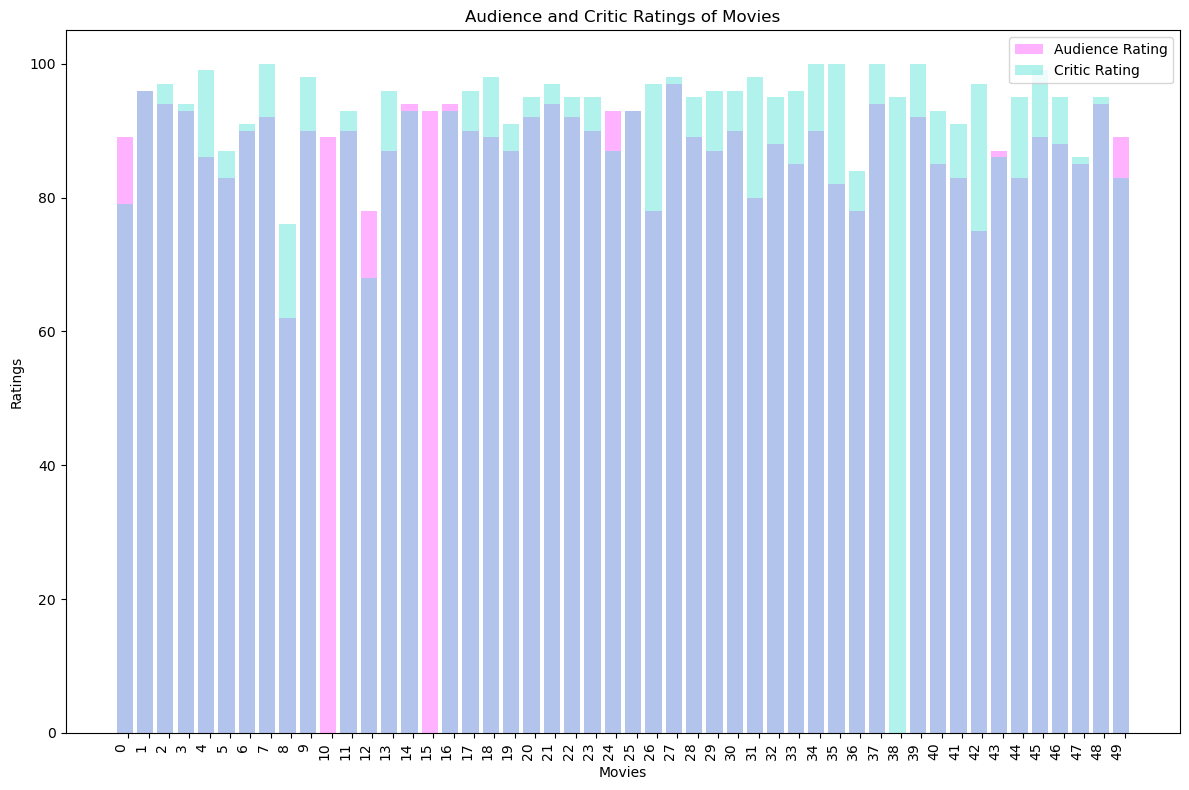

In [143]:
merged_ani_dfplot = pd.read_csv('final_animation_with_rotten.csv')

fig, ax = plt.subplots(figsize = (12,8))

index = range(len(merged_ani_dfplot))

audience = ax.bar(index, merged_ani_dfplot['audience rating'], label = 'Audience Rating', color = 'magenta', alpha = 0.3)
critic = ax.bar(index, merged_ani_dfplot['critic rating'], label = 'Critic Rating', color = 'turquoise', alpha = 0.4)

ax.set_xlabel('Movies')
ax.set_ylabel('Ratings')
ax.set_title('Audience and Critic Ratings of Movies')
ax.set_xticks([i + 0.35/2 for i in index])
ax.set_xticklabels(merged_ani_dfplot.index, rotation=90, ha='right')
ax.legend()

plt.tight_layout()
plt.show